##**TIME SERIES ML SUBMISSION**

**I GEDE KADEK RESTU KARTANA WAISNAWA**

Dicoding ID: **restuwaisnawa**

Email: **restuwaisnawa@gmail.com**

Dataset link: https://www.kaggle.com/datasets/tosinabase/intel-stock-prices-historical-data-intc

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
#get dataset
df = pd.read_csv('INTC.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.325521,0.330729,0.325521,0.325521,0.199557,10924800
1,1980-03-18,0.325521,0.328125,0.322917,0.322917,0.197961,17068800
2,1980-03-19,0.330729,0.335938,0.330729,0.330729,0.202750,18508800
3,1980-03-20,0.330729,0.334635,0.329427,0.329427,0.201952,11174400
4,1980-03-21,0.322917,0.322917,0.317708,0.317708,0.194767,12172800


In [3]:
#dataset check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10361 entries, 0 to 10360
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10361 non-null  object 
 1   Open       10361 non-null  float64
 2   High       10361 non-null  float64
 3   Low        10361 non-null  float64
 4   Close      10361 non-null  float64
 5   Adj Close  10361 non-null  float64
 6   Volume     10361 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 566.7+ KB


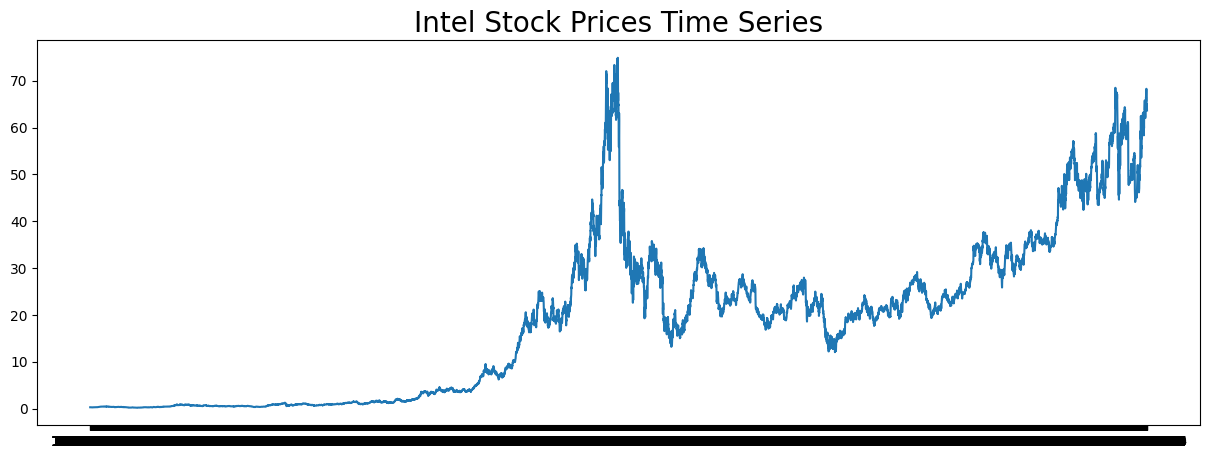

In [4]:
#plot data time series
dates = df['Date'].values
price = df['Close'].values

plt.figure(figsize=(15,5))
plt.plot(dates, price)
plt.title('Intel Stock Prices Time Series', fontsize=20);

In [5]:
#data normalization
scaler = MinMaxScaler()
price = price.reshape(-1,1)
price = scaler.fit_transform(price)

In [6]:
#train and validation set split
X_train, X_test, y_train, y_test = train_test_split(price, dates, test_size=0.2, shuffle=False)

In [7]:
#change data format for model train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=100, shuffle_buffer=1000)

In [8]:
#making model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape = [None, 1]),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [9]:
#MAE Threshold Check
mae_threshold = (price.max() - price.min()) * 10/100
print(mae_threshold)

0.1


In [10]:
#model compile
model.compile(loss='Huber',
              optimizer=Adam(learning_rate=1.0000e-04),
              metrics=['mae'])

In [11]:
#callbacks
class MaeStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold_mae):
        self.threshold_mae = threshold_mae

    def on_epoch_end(self, epoch, logs=None):
        mae = logs.get('mae')

        if mae is not None:
            if mae < self.threshold_mae:
                print(f"MAE < 10% data scale. Training stopped.")
                self.model.stop_training = True

mae_stop = MaeStop(threshold_mae=mae_threshold)

In [12]:
#model training
history = model.fit(
    train_set, epochs=100,
    validation_data=test_set,
    verbose=2,
    callbacks=[mae_stop])

Epoch 1/100
83/83 - 24s - loss: 0.0173 - mae: 0.1100 - val_loss: 0.0209 - val_mae: 0.1621 - 24s/epoch - 286ms/step
Epoch 2/100
83/83 - 17s - loss: 0.0120 - mae: 0.1135 - val_loss: 0.0211 - val_mae: 0.1628 - 17s/epoch - 210ms/step
Epoch 3/100
83/83 - 17s - loss: 0.0110 - mae: 0.1043 - val_loss: 0.0233 - val_mae: 0.1706 - 17s/epoch - 201ms/step
Epoch 4/100
MAE < 10% data scale. Training stopped.
83/83 - 17s - loss: 0.0104 - mae: 0.0981 - val_loss: 0.0270 - val_mae: 0.1857 - 17s/epoch - 199ms/step


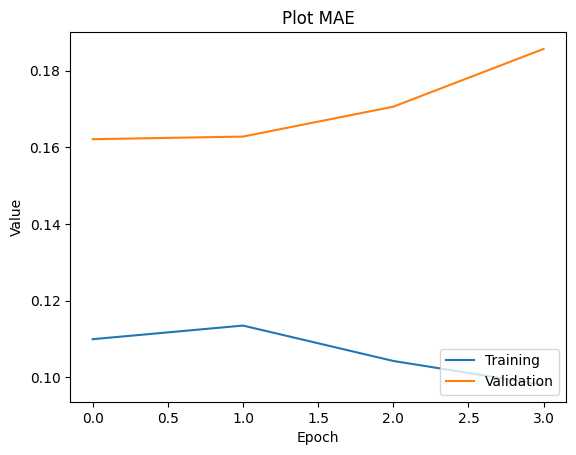

In [13]:
#plot MAE
plt.plot(history.history['mae'], label='Training')
plt.plot(history.history['val_mae'], label='Validation')
plt.title('Plot MAE')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

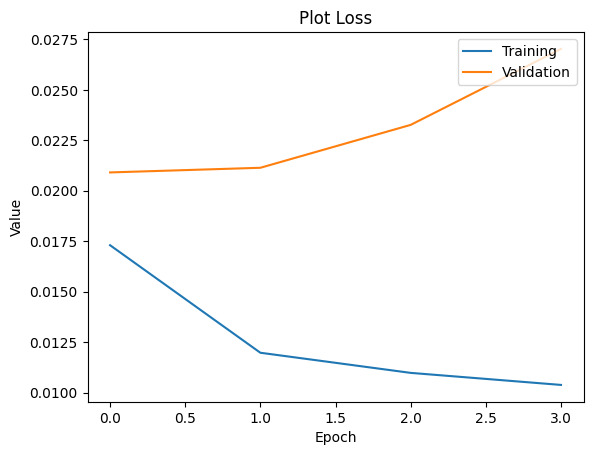

In [14]:
#plot loss
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Plot Loss')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()